In [5]:
"""
This script will split the data into train, validation and test folders.
Script Author: Md Abid Hasan
Project: Indicate_FH
Date: 12 July 2023
"""

import splitfolders
from matplotlib import pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np  
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from models import my_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.regularizers import l2
from split_data import *
import logging
logging.getLogger('tensorflow').disabled = True

"""
**Defien the network parameters which should be later in save results functions.** 
"""

seed =42
SIZE = 256
batch_size = 32
verbose = 1
epochs = 100
modelname = "2DCNN"
filter_size = 64
dropout_rt = 0.4
verbose = 1
datapath = '/home/abidhasan/Documents/Indicate_FH/data'
train_data_ratio=0.6
val_data_ratio = 0.2
test_data_ratio = 0.2
#***********__________Split the Dataset into Train, Validation and test folders________ ********
"""
split = input("Split the dataset into train, test and validation:")
if split == "yes" or "YES":
    split_data(datapath, train_data_ratio, val_data_ratio, test_data_ratio)
"""
#**********************************************************************************************


# example of progressively loading images from file
# create generator


datagen = ImageDataGenerator(rescale=1./255)

# prepare an iterators for each dataset

# load and iterate training dataset
#If I want to resize the Image then put the following param to flow_from_directory
# target_size = (128,128)
train_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/data2/train/', seed=seed, class_mode='binary', batch_size=batch_size)
# load and iterate validation dataset
val_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/data2/val/', class_mode='binary', batch_size=batch_size)
# load and iterate test dataset
test_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/data2/test/', class_mode='binary', batch_size=batch_size)
# load and iterate test dataset for the prediction perpose when the batch_size==1, as we want to predict each image.
predict_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/data2/test/', class_mode='binary', batch_size=1)


# confirm the iterator works
train_X, train_y = train_it.next()
print('Train Batch shape=%s, min=%f, max=%f' % (train_X.shape, train_X.min(), train_X.max()))
print('shape of labels=%s' % (train_y.shape))
print(np.unique(train_y, return_counts=True))

# confirm the iterator works
test_X, test_y = test_it.next()
print('Test Batch shape=%s, min=%f, max=%f' % (test_X.shape, test_X.min(), test_X.max()))
print('shape of labels=%s' % (test_y.shape))
print(np.unique(test_y, return_counts=True))



# Defining the input shape 
img_height = train_X.shape[1]
img_width = train_X.shape[2]
img_channels = train_X.shape[3]
INPUT_SHAPE = (img_height, img_width, img_channels)


# Generate the model from the script "models"

#Fit the model
train_filenames = train_it.filenames
num_train_img = len(train_filenames)
valid_filenames = val_it.filenames
num_valid_img = len(val_it.filenames)
test_filenames = test_it.filenames
num_test_img = len(test_filenames)
print('num_train_img', num_train_img)
print('num_valid_img', num_valid_img)
print('num_test_img', num_test_img)

train_steps_per_epoch = num_train_img//batch_size
val_steps_per_epoch = num_valid_img//batch_size #******* Here Considering valid image is Validation image *******
test_steps_per_epoch = num_test_img//batch_size
print("Train Steps per epoch=", train_steps_per_epoch)
print("Test Steps per epoch=", test_steps_per_epoch)
print("val Steps per epoch=", val_steps_per_epoch)


#Predecting the test imageset results
predict_filenames = predict_it.filenames
# Then set the steps of predict_generator to the total number of your test images
num_predict_img = len(predict_filenames)
predict_steps_per_epoch = num_predict_img//1
print("Predict steps per Epoch:", predict_steps_per_epoch)

Found 9490 images belonging to 2 classes.
Found 3396 images belonging to 2 classes.
Found 1783 images belonging to 2 classes.
Found 1783 images belonging to 2 classes.
Train Batch shape=(32, 256, 256, 3), min=0.000000, max=1.000000
shape of labels=32
(array([0., 1.], dtype=float32), array([16, 16]))
Test Batch shape=(32, 256, 256, 3), min=0.000000, max=1.000000
shape of labels=32
(array([0., 1.], dtype=float32), array([ 2, 30]))
num_train_img 9490
num_valid_img 3396
num_test_img 1783
Train Steps per epoch= 296
Test Steps per epoch= 55
val Steps per epoch= 106
Predict steps per Epoch: 1783


In [ ]:


#ModelCheckpoint callback saves a model at some interval. 
filepath="saved_model/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('saved_model/my_logs.csv', separator=',', append=False)
callbacks_list = [mc, es, log_csv]
 

#model_name = ["my_model", "vgg_1", "vgg_2", "vgg_3"]
#dropout_rt =[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# TODO : For loop to check the all model and dropout rates are


#************************************************************************************************
# Generating the model from Models script   
model = my_model(filter_size, INPUT_SHAPE, dropout_rt)
#model.summary()
history =  model.fit(train_it, steps_per_epoch=train_steps_per_epoch, validation_data=val_it, validation_steps=val_steps_per_epoch, epochs=epochs, verbose = verbose, callbacks = callbacks_list)
scores= model.evaluate(test_it, steps=test_steps_per_epoch)
print(f'Score for test Image: {model.metrics_names[0]} = {scores[0]}; {model.metrics_names[1]} = {scores[1] * 100}%')
model.save('2DCNN_BASE_MODEL.h5')


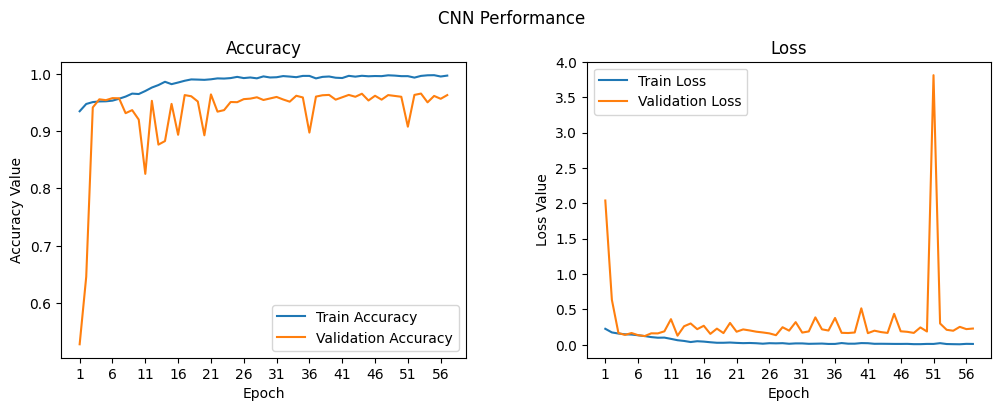

In [13]:
#*************************************************************************************************
#Plotting the Train and Validation accuracy and loss.

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()
#plt.savefig('filtered_image/CNN_TRAIN_VS_VALIDATION_LOSS.png', bbox_inches='tight')

In [6]:
#Load the saved model
from keras.models import load_model
model = load_model('2DCNN_BASE_MODEL.h5')

   1/1783 [..............................] - ETA: 5:07

2023-09-08 09:56:27.903512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-08 09:56:28.013489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-08 09:56:28.052487: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-09-08 09:56:28.052505: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-09-08 09:56:28.052571: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.

1783/1783 [==============================] - 7s 4ms/step


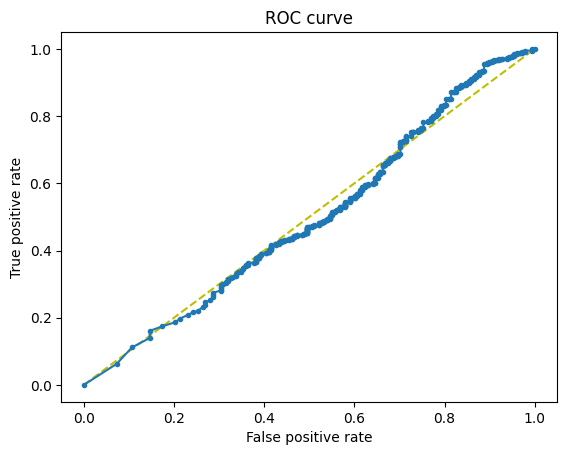

In [7]:
#************************************************************************************************
#Plotting the ROC and AUC from the evaluated model
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(predict_it, steps=predict_steps_per_epoch).ravel()
y_test = test_it.classes

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.savefig('filtered_image/ROC_CURVE.png', bbox_inches='tight')
plt.show()


In [34]:
"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 
optimal_cutoff = ideal_roc_thresh['thresholds'].values
#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn

Ideal threshold is:  134    0.99998
Name: thresholds, dtype: float32


In [35]:
#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier 
#is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.4976513003605306


  43/1783 [..............................] - ETA: 6s

2023-09-08 14:50:47.635324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1783/1783 [==============================] - 6s 4ms/step
Printing the Predicted class details:
 (array([0, 1]), array([ 226, 1557]))
Printing the True class details:
 (array([0, 1], dtype=int32), array([ 178, 1605]))
Classification report
               precision    recall  f1-score   support

    effected       0.12      0.16      0.14       178
not_effected       0.90      0.88      0.89      1605

    accuracy                           0.80      1783
   macro avg       0.51      0.52      0.51      1783
weighted avg       0.83      0.80      0.81      1783

Confusion Matrix
 [[  28  150]
 [ 198 1407]]
Average F1 Score per class: [0.13861386 0.88994307]
Average_Macro F1 Score of the Model: 0.5142784676949669
Average_Weighted F1 score of the Model: 0.8149365682012473


NameError: name 'scores' is not defined

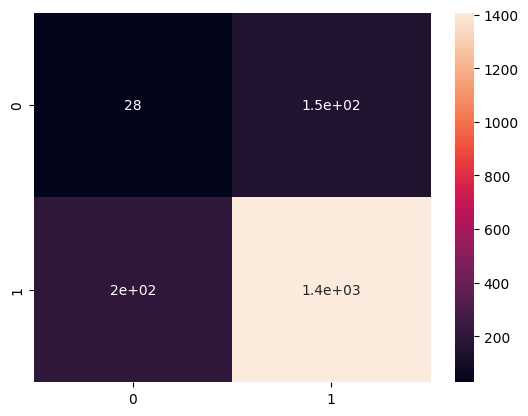

In [38]:

#************************************************************************************************
#Printing the confusion matrix, F1 score and accuracy on test dataset.

# model = tf.keras.models.load_model(saved_model_dir + 'baseline_model_load_from_disk.hdf5', compile=False)

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, f1_score, classification_report
mythreshold = 0.99
predicted_class = (model.predict(predict_it, steps=predict_steps_per_epoch)>= mythreshold).astype(int)
print('Printing the Predicted class details:\n', np.unique(predicted_class, return_counts=True))
true_classes = test_it.classes
print('Printing the True class details:\n', np.unique(true_classes, return_counts=True))
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_class, target_names=class_labels)
print('Classification report\n', report)
cm = confusion_matrix(true_classes, predicted_class)
print('Confusion Matrix\n', cm)
import seaborn as sns
sns.heatmap(cm, annot=True)
f1scores_per_class = (f1_score(true_classes, predicted_class, average=None))
average_fscore_macro = (f1_score(true_classes, predicted_class, average="macro"))
average_fscore_weighted = (f1_score(true_classes, predicted_class, average="weighted"))
print('Average F1 Score per class:', f1scores_per_class)
print('Average_Macro F1 Score of the Model:', average_fscore_macro)
print('Average_Weighted F1 score of the Model:', average_fscore_weighted)
print(f'Accuracy of the Model: {scores[1] * 100}%')


In [ ]:
"""
def createFitEvaluateModel(
    modelName, 
    training_data, 
    training_labels, 
    testing_data, 
    testing_labels, 
    verbose = 2, 
    epochs = 10, 
    batch_size = 500, 
    withBatchNormalization = False):

    callbacks_list = []
    
    print("input shape: ", training_data.shape[1], training_data.shape[2])
    print_info("Create model")
    
    nKerns = [50,40,30]
    filterSizes = [(11,1),(10,1),(6,1)]
    poolSizes = [(2,1),(3,1),(1,1)]
    
    # Create model
    model = modelName(inputShape = (training_data.shape[1], training_data.shape[2], 1)  ,
                    nkerns = nKerns,
                    filterSizes = filterSizes,
                    poolSizes = poolSizes,
                    activationConv = 'relu',
                    inputMLP = 1000,
                    activationMLP = 'relu',
                    nbClasses = numberOfClasses,
                    withBatchNormalization = withBatchNormalization)

    model.compile(loss=keras.losses.categorical_crossentropy, # For autoencoders
          optimizer=keras.optimizers.Adadelta(),
          #optimizer=keras.optimizers.sgd(lr=learningRate,decay=1e-6),
          metrics=['acc', fmeasure])

    print_info("Model created")
    print(model.summary())
       
    # Create callback checkpoint
    path = './tmp/checkpoint/'
    filename = 'checkpoint.hdf5'
    if not os.path.exists(path):
        os.makedirs(path)
    checkpoint = ModelCheckpoint(path+filename, monitor='fmeasure',save_best_only=True,save_weights_only=False)
    callbacks_list.append(checkpoint)

    print("Callbackslist", callbacks_list)
    print_info("Fit model:")

    # Fit the model
    model.fit(training_data, training_labels,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(testing_data, testing_labels),             
              callbacks=callbacks_list)

    model.load_weights(path+filename)

    print_info("Evaluate model: ")
    
    # Evaluate model
    loss, accuracy, fscore = model.evaluate(testing_data, testing_labels, verbose = verbose)    
    
    return loss, accuracy, fscore, model

def print_info(info):
    print("\n")
    print('-----------------------------------------------------------------------------')
    print(info)
    print('-----------------------------------------------------------------------------')
    print("\n")



def test_all_models(    
    verbose = 2, 
    epochs = 10, 
    batch_size = 100,
    saveModel = False):
    ''' Tests all available networks'''
    
     print_info("Load dataset")

    dataPath = "./dataset/64/"
    training_data, training_labels, trainShape, testing_data, testing_labels, testShape, _, _ = loadCleanOpportunityData(dataPath,permute = True)
    training_data, training_labels, testing_data, testing_labels = preprocess_dataset(training_data, training_labels, testing_data, testing_labels, project_labels = False)

    print_info("Dataset laoded")

    model_names = [normConv1, normConv2, normConv3, normConv4, normConv5, normConv6, normConv7, normConv8]

    for model_name in model_names:
      
        test_model(model_name, training_data, training_labels, testing_data, testing_labels, verbose =verbose, epochs = epochs, batch_size = batch_size, withBatchNormalization = True, saveModel = saveModel)
        keras.backend.clear_session()

def test_model(
    model_name,
    training_data,
    training_labels,
    testing_data,
    testing_labels,
    verbose,
    epochs,
    batch_size,
    withBatchNormalization = True,
    saveModel = False):
    
    start_time = datetime.now() 
    print(model_name)
    loss, accuracy, fscore, model = createFitEvaluateModel(model_name, training_data, training_labels, testing_data, testing_labels, verbose =verbose, epochs = epochs, batch_size = batch_size, withBatchNormalization = True)

    testing_pred, true_labels = predict_on_model(model, testing_data, testing_labels)
    fscores_per_class = (f1_score(true_labels, testing_pred, average = None))
    average_fscore = (f1_score(true_labels, testing_pred, average = "macro"))

    time_elapsed = datetime.now() - start_time

    saveResultsCSV("Test all models", model_name, epochs, batch_size, accuracy, average_fscore, fscores_per_class.tolist(), model.layers, time_elapsed, "", "")

    if saveModel:
        loadedModel = load_model()
        if loadedModel is None:
            print_info("Save new model...")
            save_model(model)
            print_info("Saved new model. Average F1 score: {}".format(average_fscore))
        else:
            testing_pred, true_labels = predict_on_model(loadedModel, testing_data, testing_labels)
            

   
            old_average_fscore = (f1_score(true_labels, testing_pred, average = "macro"))

            if (average_fscore > old_average_fscore):
                save_model(model)
                print_info("Saved a better model. Average F1 score: {}, Old average F1 score: {}".format(average_fscore, old_average_fscore))
            else:
                print_info("Existing model is still the best. Average F1 score: {}, Old average F1 score: {}".format(average_fscore, old_average_fscore))
                
"""